In [1]:
# Reference (GitHub):- https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb

In [2]:
#This notebook is used to generate the model for Attention
#attention + Flickr8 + Resnet50 + 50 Epochs

In [3]:
!rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

In [4]:

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import optimizers
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf

In [5]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [6]:
image_path = "/content/Flicker8k_Dataset"
dir_Flickr_text = "/content/Flickr8k.token.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [7]:
dir_Flickr_text

'/content/Flickr8k.token.txt'

In [8]:
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop

In [9]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [10]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


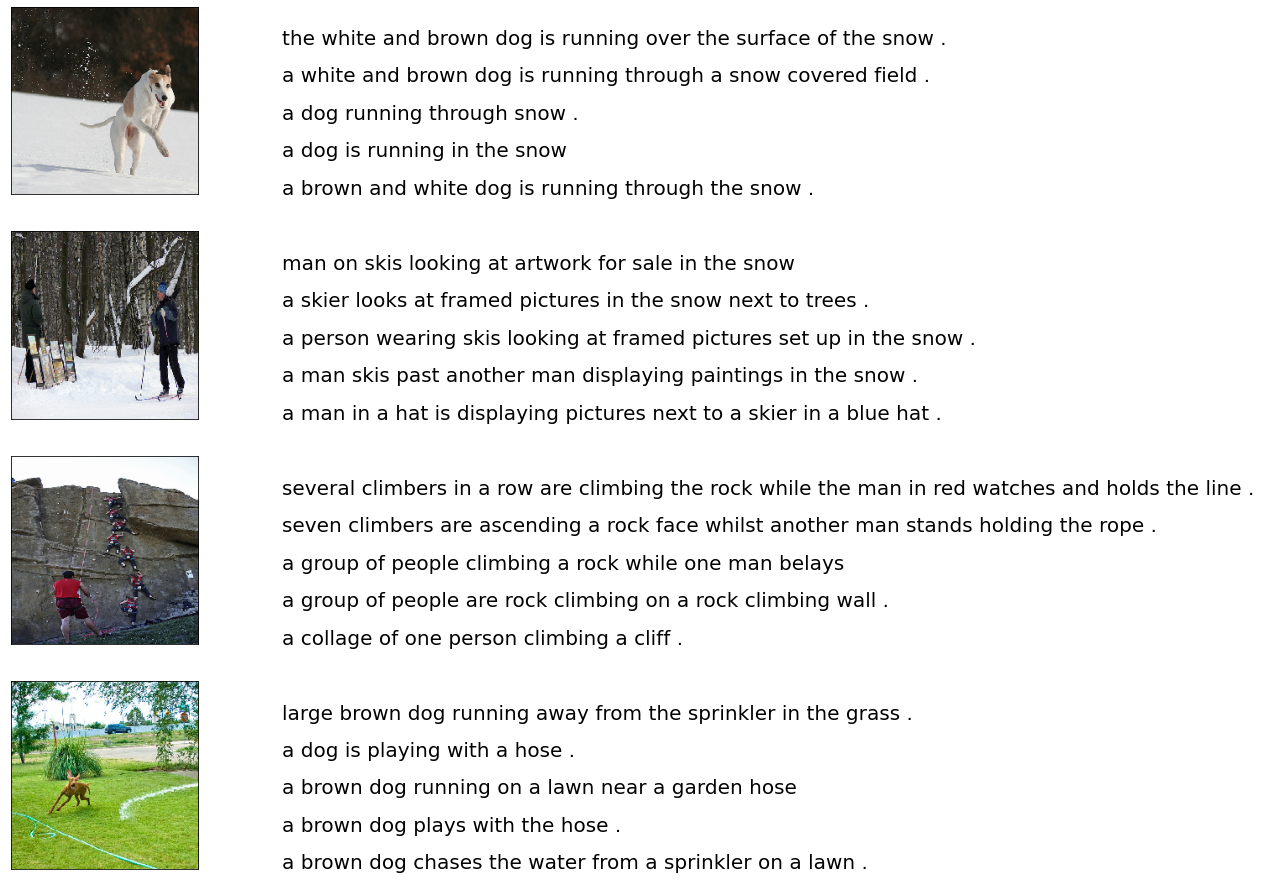

In [11]:
npic = 5
npix = 224
target_size = (npix,npix,3)  #224,224,3
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [12]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [13]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [14]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [15]:
PATH = "/content/Flicker8k_Dataset/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [16]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [17]:
#Clarify
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [18]:
def load_image(image_path):    
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   print('Shape before preprocess:', img.shape)
   #img = preprocess_input(img)
   print('Shape after preprocess:' , img.shape)

   return img, image_path #224,224,3

#image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

image_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224, 224,3),pooling="avg")

new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [19]:
image_model_check = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [20]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

Shape before preprocess: (224, 224, 3)
Shape after preprocess: (224, 224, 3)


In [21]:
len(encode_train)

8091

In [22]:
type(image_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [23]:
for x,y in image_dataset:
    print(x.shape,y.shape)
    break

(64, 224, 224, 3) (64,)


In [24]:
encode_train[0]

'/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

In [25]:
type(encode_train),type(img_name_vector),type(image_dataset)

(list, list, tensorflow.python.data.ops.dataset_ops.BatchDataset)

In [26]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 print(batch_features.shape) #(64, 7, 7, 512)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))
 #print(batch_features.shape)  #(64, 49, 512)
 

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   #print(path_of_feature)
   np.save(path_of_feature, bf.numpy())
 #break

  1%|          | 1/127 [00:09<20:28,  9.75s/it]

(64, 7, 7, 2048)


  2%|▏         | 2/127 [00:10<08:49,  4.24s/it]

(64, 7, 7, 2048)


  2%|▏         | 3/127 [00:10<04:58,  2.40s/it]

(64, 7, 7, 2048)


  3%|▎         | 4/127 [00:10<03:14,  1.58s/it]

(64, 7, 7, 2048)


  4%|▍         | 5/127 [00:10<02:13,  1.10s/it]

(64, 7, 7, 2048)


  5%|▍         | 6/127 [00:11<01:37,  1.24it/s]

(64, 7, 7, 2048)


  6%|▌         | 7/127 [00:11<01:16,  1.56it/s]

(64, 7, 7, 2048)


  6%|▋         | 8/127 [00:11<01:02,  1.90it/s]

(64, 7, 7, 2048)


  7%|▋         | 9/127 [00:11<00:51,  2.28it/s]

(64, 7, 7, 2048)


  8%|▊         | 10/127 [00:12<00:44,  2.65it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


  9%|▉         | 12/127 [00:12<00:37,  3.10it/s]

(64, 7, 7, 2048)


 10%|█         | 13/127 [00:13<00:34,  3.29it/s]

(64, 7, 7, 2048)


 11%|█         | 14/127 [00:13<00:33,  3.37it/s]

(64, 7, 7, 2048)


 12%|█▏        | 15/127 [00:13<00:31,  3.58it/s]

(64, 7, 7, 2048)


 13%|█▎        | 16/127 [00:13<00:31,  3.55it/s]

(64, 7, 7, 2048)


 13%|█▎        | 17/127 [00:14<00:29,  3.74it/s]

(64, 7, 7, 2048)


 14%|█▍        | 18/127 [00:14<00:28,  3.87it/s]

(64, 7, 7, 2048)


 15%|█▍        | 19/127 [00:14<00:28,  3.73it/s]

(64, 7, 7, 2048)


 16%|█▌        | 20/127 [00:14<00:27,  3.87it/s]

(64, 7, 7, 2048)


 17%|█▋        | 21/127 [00:15<00:27,  3.85it/s]

(64, 7, 7, 2048)


 17%|█▋        | 22/127 [00:15<00:29,  3.62it/s]

(64, 7, 7, 2048)


 18%|█▊        | 23/127 [00:15<00:27,  3.74it/s]

(64, 7, 7, 2048)


 19%|█▉        | 24/127 [00:15<00:26,  3.82it/s]

(64, 7, 7, 2048)


 20%|█▉        | 25/127 [00:16<00:27,  3.70it/s]

(64, 7, 7, 2048)


 20%|██        | 26/127 [00:16<00:27,  3.72it/s]

(64, 7, 7, 2048)


 21%|██▏       | 27/127 [00:16<00:26,  3.83it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 23%|██▎       | 29/127 [00:17<00:26,  3.77it/s]

(64, 7, 7, 2048)


 24%|██▎       | 30/127 [00:17<00:25,  3.82it/s]

(64, 7, 7, 2048)


 24%|██▍       | 31/127 [00:17<00:25,  3.81it/s]

(64, 7, 7, 2048)


 25%|██▌       | 32/127 [00:18<00:25,  3.70it/s]

(64, 7, 7, 2048)


 26%|██▌       | 33/127 [00:18<00:24,  3.80it/s]

(64, 7, 7, 2048)


 27%|██▋       | 34/127 [00:18<00:25,  3.64it/s]

(64, 7, 7, 2048)


 28%|██▊       | 35/127 [00:18<00:24,  3.75it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 29%|██▉       | 37/127 [00:19<00:24,  3.69it/s]

(64, 7, 7, 2048)


 30%|██▉       | 38/127 [00:19<00:23,  3.76it/s]

(64, 7, 7, 2048)


 31%|███       | 39/127 [00:19<00:22,  3.87it/s]

(64, 7, 7, 2048)


 31%|███▏      | 40/127 [00:20<00:23,  3.66it/s]

(64, 7, 7, 2048)


 32%|███▏      | 41/127 [00:20<00:24,  3.56it/s]

(64, 7, 7, 2048)


 33%|███▎      | 42/127 [00:20<00:23,  3.70it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 35%|███▍      | 44/127 [00:21<00:22,  3.72it/s]

(64, 7, 7, 2048)


 35%|███▌      | 45/127 [00:21<00:22,  3.72it/s]

(64, 7, 7, 2048)


 36%|███▌      | 46/127 [00:21<00:21,  3.69it/s]

(64, 7, 7, 2048)


 37%|███▋      | 47/127 [00:22<00:21,  3.81it/s]

(64, 7, 7, 2048)


 38%|███▊      | 48/127 [00:22<00:21,  3.68it/s]

(64, 7, 7, 2048)


 39%|███▊      | 49/127 [00:22<00:20,  3.77it/s]

(64, 7, 7, 2048)


 39%|███▉      | 50/127 [00:22<00:19,  3.85it/s]

(64, 7, 7, 2048)


 40%|████      | 51/127 [00:23<00:20,  3.68it/s]

(64, 7, 7, 2048)


 41%|████      | 52/127 [00:23<00:20,  3.73it/s]

(64, 7, 7, 2048)


 42%|████▏     | 53/127 [00:23<00:19,  3.74it/s]

(64, 7, 7, 2048)


 43%|████▎     | 54/127 [00:23<00:19,  3.74it/s]

(64, 7, 7, 2048)


 43%|████▎     | 55/127 [00:24<00:19,  3.68it/s]

(64, 7, 7, 2048)


 44%|████▍     | 56/127 [00:24<00:18,  3.81it/s]

(64, 7, 7, 2048)


 45%|████▍     | 57/127 [00:24<00:18,  3.73it/s]

(64, 7, 7, 2048)


 46%|████▌     | 58/127 [00:24<00:18,  3.74it/s]

(64, 7, 7, 2048)


 46%|████▋     | 59/127 [00:25<00:17,  3.83it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 48%|████▊     | 61/127 [00:25<00:17,  3.88it/s]

(64, 7, 7, 2048)


 49%|████▉     | 62/127 [00:26<00:17,  3.73it/s]

(64, 7, 7, 2048)


 50%|████▉     | 63/127 [00:26<00:16,  3.77it/s]

(64, 7, 7, 2048)


 50%|█████     | 64/127 [00:26<00:16,  3.91it/s]

(64, 7, 7, 2048)


 51%|█████     | 65/127 [00:26<00:16,  3.73it/s]

(64, 7, 7, 2048)


 52%|█████▏    | 66/127 [00:27<00:16,  3.71it/s]

(64, 7, 7, 2048)


 53%|█████▎    | 67/127 [00:27<00:15,  3.76it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 54%|█████▎    | 68/127 [00:27<00:14,  4.02it/s]

(64, 7, 7, 2048)


 55%|█████▌    | 70/127 [00:28<00:15,  3.77it/s]

(64, 7, 7, 2048)


 56%|█████▌    | 71/127 [00:28<00:14,  3.87it/s]

(64, 7, 7, 2048)


 57%|█████▋    | 72/127 [00:28<00:14,  3.89it/s]

(64, 7, 7, 2048)


 57%|█████▋    | 73/127 [00:28<00:14,  3.74it/s]

(64, 7, 7, 2048)


 58%|█████▊    | 74/127 [00:29<00:14,  3.75it/s]

(64, 7, 7, 2048)


 59%|█████▉    | 75/127 [00:29<00:13,  3.80it/s]

(64, 7, 7, 2048)


 60%|█████▉    | 76/127 [00:29<00:13,  3.82it/s]

(64, 7, 7, 2048)


 61%|██████    | 77/127 [00:30<00:13,  3.70it/s]

(64, 7, 7, 2048)


 61%|██████▏   | 78/127 [00:30<00:11,  4.10it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 62%|██████▏   | 79/127 [00:30<00:13,  3.69it/s]

(64, 7, 7, 2048)


 64%|██████▍   | 81/127 [00:31<00:13,  3.43it/s]

(64, 7, 7, 2048)


 65%|██████▍   | 82/127 [00:31<00:13,  3.44it/s]

(64, 7, 7, 2048)


 65%|██████▌   | 83/127 [00:31<00:12,  3.55it/s]

(64, 7, 7, 2048)


 66%|██████▌   | 84/127 [00:31<00:12,  3.54it/s]

(64, 7, 7, 2048)


 67%|██████▋   | 85/127 [00:32<00:11,  3.53it/s]

(64, 7, 7, 2048)


 68%|██████▊   | 86/127 [00:32<00:11,  3.64it/s]

(64, 7, 7, 2048)


 69%|██████▊   | 87/127 [00:32<00:11,  3.59it/s]

(64, 7, 7, 2048)


 69%|██████▉   | 88/127 [00:33<00:10,  3.58it/s]

(64, 7, 7, 2048)


 70%|███████   | 89/127 [00:33<00:10,  3.64it/s]

(64, 7, 7, 2048)


 71%|███████   | 90/127 [00:33<00:10,  3.69it/s]

(64, 7, 7, 2048)


 72%|███████▏  | 91/127 [00:33<00:09,  3.60it/s]

(64, 7, 7, 2048)


 72%|███████▏  | 92/127 [00:34<00:09,  3.75it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 74%|███████▍  | 94/127 [00:34<00:08,  3.70it/s]

(64, 7, 7, 2048)


 75%|███████▍  | 95/127 [00:34<00:08,  3.79it/s]

(64, 7, 7, 2048)


 76%|███████▌  | 96/127 [00:35<00:07,  3.88it/s]

(64, 7, 7, 2048)


 76%|███████▋  | 97/127 [00:35<00:07,  3.79it/s]

(64, 7, 7, 2048)


 77%|███████▋  | 98/127 [00:35<00:07,  3.88it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 79%|███████▊  | 100/127 [00:36<00:06,  3.99it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 80%|████████  | 102/127 [00:36<00:06,  3.81it/s]

(64, 7, 7, 2048)


 81%|████████  | 103/127 [00:37<00:06,  3.48it/s]

(64, 7, 7, 2048)


 82%|████████▏ | 104/127 [00:37<00:06,  3.66it/s]

(64, 7, 7, 2048)


 83%|████████▎ | 105/127 [00:37<00:05,  3.67it/s]

(64, 7, 7, 2048)


 83%|████████▎ | 106/127 [00:37<00:05,  3.82it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)

 84%|████████▍ | 107/127 [00:38<00:05,  3.65it/s]

 85%|████████▌ | 108/127 [00:38<00:05,  3.67it/s]

(64, 7, 7, 2048)


 86%|████████▌ | 109/127 [00:38<00:04,  3.63it/s]

(64, 7, 7, 2048)


 87%|████████▋ | 110/127 [00:38<00:04,  3.72it/s]

(64, 7, 7, 2048)


 87%|████████▋ | 111/127 [00:39<00:04,  3.53it/s]

(64, 7, 7, 2048)


 88%|████████▊ | 112/127 [00:39<00:04,  3.74it/s]

(64, 7, 7, 2048)


 89%|████████▉ | 113/127 [00:39<00:03,  3.77it/s]

(64, 7, 7, 2048)


 90%|████████▉ | 114/127 [00:40<00:03,  3.82it/s]

(64, 7, 7, 2048)


 91%|█████████ | 115/127 [00:40<00:03,  3.97it/s]

(64, 7, 7, 2048)


 91%|█████████▏| 116/127 [00:40<00:02,  3.70it/s]

(64, 7, 7, 2048)


 92%|█████████▏| 117/127 [00:40<00:02,  3.67it/s]

(64, 7, 7, 2048)


 93%|█████████▎| 118/127 [00:41<00:02,  3.72it/s]

(64, 7, 7, 2048)


 94%|█████████▎| 119/127 [00:41<00:02,  3.75it/s]

(64, 7, 7, 2048)


 94%|█████████▍| 120/127 [00:41<00:01,  3.80it/s]

(64, 7, 7, 2048)
(64, 7, 7, 2048)


 95%|█████████▌| 121/127 [00:41<00:01,  3.53it/s]

(64, 7, 7, 2048)


 96%|█████████▌| 122/127 [00:42<00:01,  3.13it/s]

(64, 7, 7, 2048)


 98%|█████████▊| 124/127 [00:43<00:01,  2.55it/s]

(64, 7, 7, 2048)


 98%|█████████▊| 125/127 [00:43<00:00,  2.65it/s]

(64, 7, 7, 2048)


 99%|█████████▉| 126/127 [00:43<00:00,  2.87it/s]

(64, 7, 7, 2048)


100%|██████████| 127/127 [00:44<00:00,  3.05it/s]

(27, 7, 7, 2048)


100%|██████████| 127/127 [01:21<00:00,  1.55it/s]

CPU times: user 49.7 s, sys: 6.07 s, total: 55.7 s
Wall time: 1min 21s


In [27]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [28]:
len(cap_vector[0])

33

In [29]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [30]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [31]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [32]:
#Clarify
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
#  print(img_name.decode('utf-8')+'.npy')
#  print(type(img_tensor))
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
img_tensor = np.load('/content/Flicker8k_Dataset/3648988742_888a16f600.jpg.npy')
print(type(img_tensor))

<class 'numpy.ndarray'>


In [34]:
for x,y in dataset:
    print(x)
    break

tf.Tensor(
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.56091726 0.         0.         ... 2.5784056  0.         0.        ]
  [0.6207093  0.         0.         ... 4.3190975  0.         0.        ]
  [2.8305292  1.4195449  0.         ... 6.4226484  0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.      

In [35]:
class Resnet50_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(Resnet50_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   
#We define our RNN based on GPU/CPU capabilities-

def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [36]:
encoder = Resnet50_Encoder(embedding_dim)

In [37]:
#For later
#from torchsummary import summary
#summary(encoder, input_size=(1, 49, 3))

In [38]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = Resnet50_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [39]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask
 return tf.reduce_mean(loss_)

In [40]:
[tokenizer.word_index['<start>']] * BATCH_SIZE

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [41]:
 dec_input1 = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

In [42]:
dec_input1

<tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]], dtype=int32)>

In [43]:
dec_input1.shape

TensorShape([64, 1])

In [44]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [45]:
start_epoch=0

In [46]:
EPOCHS = 50
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.7910
Epoch 1 Batch 100 Loss 1.7343
Epoch 1 Batch 200 Loss 1.4599
Epoch 1 Batch 300 Loss 1.4093
Epoch 1 Batch 400 Loss 1.2365
Epoch 1 Loss 1.475351
Time taken for 1 epoch 104.66641688346863 sec

Epoch 2 Batch 0 Loss 1.2454
Epoch 2 Batch 100 Loss 1.2326
Epoch 2 Batch 200 Loss 1.0981
Epoch 2 Batch 300 Loss 1.1853
Epoch 2 Batch 400 Loss 1.0672
Epoch 2 Loss 1.122615
Time taken for 1 epoch 62.19587779045105 sec

Epoch 3 Batch 0 Loss 0.9769
Epoch 3 Batch 100 Loss 1.1090
Epoch 3 Batch 200 Loss 1.0651
Epoch 3 Batch 300 Loss 0.9533
Epoch 3 Batch 400 Loss 0.9368
Epoch 3 Loss 1.006022
Time taken for 1 epoch 61.94608116149902 sec

Epoch 4 Batch 0 Loss 0.9733
Epoch 4 Batch 100 Loss 0.9809
Epoch 4 Batch 200 Loss 0.9724
Epoch 4 Batch 300 Loss 0.8543
Epoch 4 Batch 400 Loss 0.9440
Epoch 4 Loss 0.921342
Time taken for 1 epoch 62.31881499290466 sec

Epoch 5 Batch 0 Loss 0.8634
Epoch 5 Batch 100 Loss 0.8483
Epoch 5 Batch 200 Loss 0.9017
Epoch 5 Batch 300 Loss 0.7491
Epoch 5 Batch 400

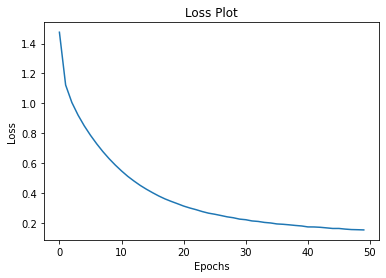

In [47]:
#Let’s plot the error graph:

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [48]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [49]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [50]:
decoder.save_weights('/content/image_caption_decoder_attention50_resnet50.h5')

In [51]:
encoder.save_weights('/content/image_caption_encoder_attention50_resnet50.h5')

Shape before preprocess: (224, 224, 3)
Shape after preprocess: (224, 224, 3)
BELU score: 6.7393716283177e-153
Real Caption: Two white dogs are playing in the snow
Prediction Caption: two white dogs walk on snow covered ground


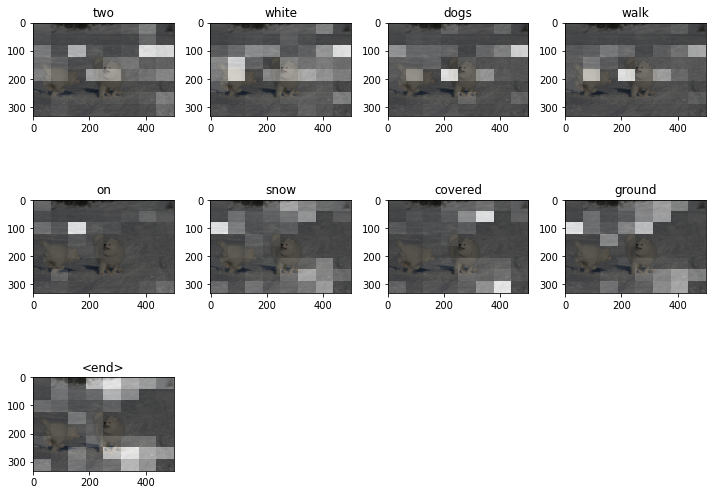

In [52]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/Flicker8k_Dataset/2319175397_3e586cfaf8.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'Two white dogs are playing in the snow'
first = real_caption.split(' ', 1)[1]
real_caption = 'Two white dogs are playing in the snow'

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

Shape before preprocess: (224, 224, 3)
Shape after preprocess: (224, 224, 3)
Real Caption: person on bike is making high jump along trail in the woods
Prediction Caption: person jumping off ramp in barren forest


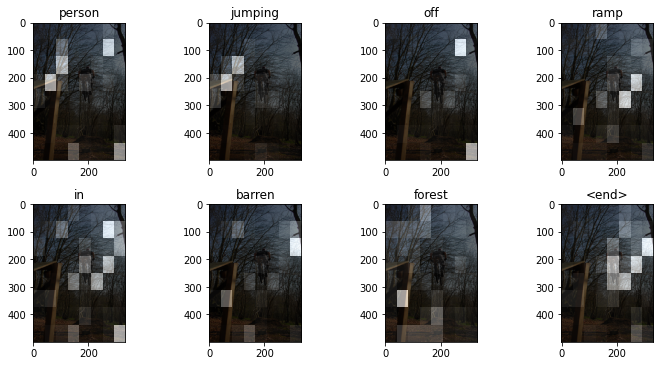

time took to Predict: 1 sec


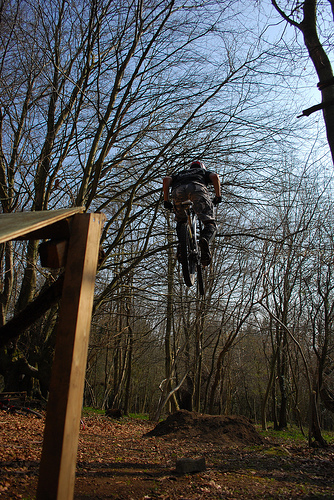

In [53]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Shape before preprocess: (224, 224, 3)
Shape after preprocess: (224, 224, 3)
BELU score: 9.25732495472854e-230
Real Caption: man in sunglasses on an overpass
Prediction Caption: there are two men with sunglasses one of which is wearing hat and backpack


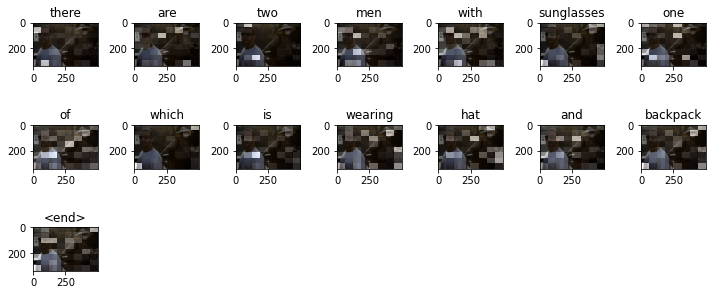

In [54]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

In [55]:
blue_1 = 0
blue_2 = 0
blue_3 = 0
blue_4 = 0
blue_count_1 = 0
blue_count_2 = 0
blue_count_3 = 0
blue_count_4 = 0
for j in range(250):    
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    # remove <start> and <end> from the real_caption
    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)
    plt.show()
    #Image.open(img_name_val[rid])
    #remove "<unk>" in result
    for i in result:
        if i=="<unk>":
            result.remove(i)

    for i in real_caption:
        if i=="<unk>":
            real_caption.remove(i)

    #remove <end> from result        
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = result
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', result_final)
    score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    if score > 0.1:
        blue_1 +=score
        blue_count_1 +=1
    print(f"BLEU-1 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    if score > 0.1:
        blue_2 +=score
        blue_count_2 +=1
    print(f"BLEU-2 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    if score > 0.1:
        blue_3 +=score
        blue_count_3 += 1
    print(f"BLEU-3 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    if score > 0.1:
        blue_4 +=score
        blue_count_4 += 1
    print(f"BLEU-4 score: {score*100}")

print(f"BLEU-1 count: {blue_count_1}")
print(f"BLEU-2 count: {blue_count_2}")
print(f"BLEU-3 count: {blue_count_3}")
print(f"BLEU-4 count: {blue_count_4}")
print(f"BLEU-1 Total: {blue_1}")
print(f"BLEU-2 Total: {blue_2}")
print(f"BLEU-3 Total: {blue_3}")
print(f"BLEU-4 Total: {blue_4}")
if blue_count_1 > 0:
    print(f"BLEU-1 Average: {blue_1/blue_count_1}")
if blue_count_2 > 0:
    print(f"BLEU-2 Average: {blue_2/blue_count_2}")
if blue_count_3 > 0:
    print(f"BLEU-3 Average: {blue_3/blue_count_3}")
if blue_count_4 > 0:
    print(f"BLEU-4 Average: {blue_4/blue_count_4}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', result_final)

    #plot_attention(image, result, attention_plot)
if blue_count_1 > 0:
    print("Blue score count > 0.1",blue_count_1)
    print("Blue score average >0.1",blue_1/blue_count_1)

Output hidden; open in https://colab.research.google.com to view.

In [56]:
#-------------------END------------------------